## Exercise 4. Read and analyse an XML file from a GPS
The file *activity_779202142.gpx* in the "data" directory is downloaded from a GPS watch used to record a run (a marathon in this case). The file is in XML format. XML stands for "eXtendible Markup Language" and is a standard format used to pass information from different programs and on the internet. You can read more about XML for instance on the Wikipedia: https://en.wikipedia.org/wiki/XML

Python has methods to navigate through an XML file and capture the information contained in it. The skeleton program below contains all the basics needed to open the file and access the information about the "track" corresponding to the run. 

You should use *longitude* and *latitute* to convert the information into a 2D positions in metres, with (0,0) being the starting point. The *time* information, given in UTC, can be converted into seconds, with t=0s being the time of the first point. The elevation is given in metres. 

You should look at the xml file (open it with an editor) to see how it is structured and understand how the piece of code provided below reads it and unpacks the information into an array of dictionaries. 

The dictionaries can then put into numpy arrays to be used for your data analysis. This is not the most efficient way of doing this, as one could put the information straight into arrays. Doing this way, however, it is much easier to extract informatio of a specific entry (as shown below). 

This operation of reading a file in a specific format, clean up the records, and eventually prepare everything in a format that can be easily analysed is often referred to as "data wrangling".

Once you have x, y, h and t (position, elevation, time) plot:
- The route taken by the runner in the (x,y) plane in km
- The distance run as a function of time (in minutes), with t=0 being the start of the run
- The speed of the runner (in m/s) as a function of time (in min)
- The speed of the runner (in m/s) as a function of the distance ran (in km)
- The elevation (in m) as a function of the distance run (in km)
- What was the time taken to run the "white peak" marathon?

** Total [10 marks] ** 

In [3]:
#Given function for xml imports_list
import glob
import xml.etree.ElementTree as ET

# Function parseXML
# Input: xml_file
# Output array of elements with coordinates lat, lon, ele, time. 
def parseXML(xml_file):
    tree = ET.ElementTree(file=xml_file)
    root = tree.getroot()
    
    xml=[]
    for child in root[1]:
        if child.tag == "{http://www.topografix.com/GPX/1/1}trkseg":
            for step_child in child:
                evt={} # declare a new dictionary
                evt['lat'] = step_child.get('lat')
                evt['lon'] = step_child.get('lon')
                evt['ele'] = step_child[0].text
                evt['time'] = step_child[1].text
                
                xml.append(evt)
    return xml

# Path may need adjusting, depending on folder configuration
xml_file = glob.glob('../data/activity_779202142.gpx')
xml = parseXML(xml_file[0])

# Print out the size of the array
print("I read ",len(xml)," elements")



I read  3260  elements


In [0]:
""" Examples given
# Example of a printout of a specific record
print("coordinates of point 55")
print(xml[55])

# Example on how to get the Delta t between two points:
import dateutil.parser as dtp
from dateutil.relativedelta import *

t0=(dtp.parse(xml[0]['time']) )
t55=(dtp.parse(xml[55]['time']) )
print(t0)
print(t55)
print("Delta time is:",(t55-t0).total_seconds() )


# Example of how to calculate a vector with the difference between adjacent elemets
# deltaA=A[1:]-A[:-1] # Note the length of the vector will be n-1

#Example of how to add elements of a vector and keep a cumulative sum
# Asum=A.cumsum()
"""

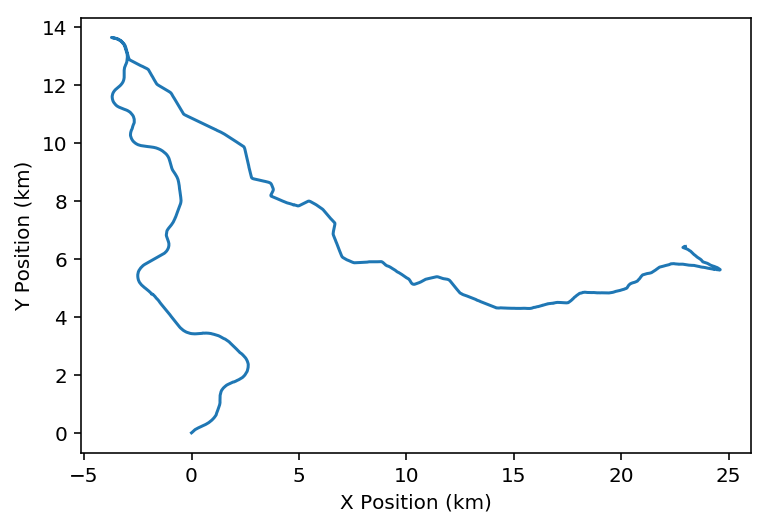

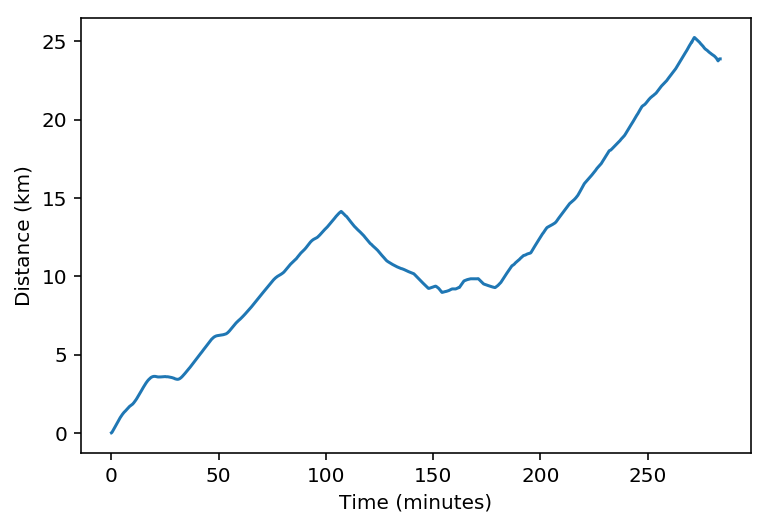

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:134: RuntimeWarning: divide by zero encountered in double_scalars


ValueError: x and y must have same first dimension, but have shapes (3260,) and (3259,)

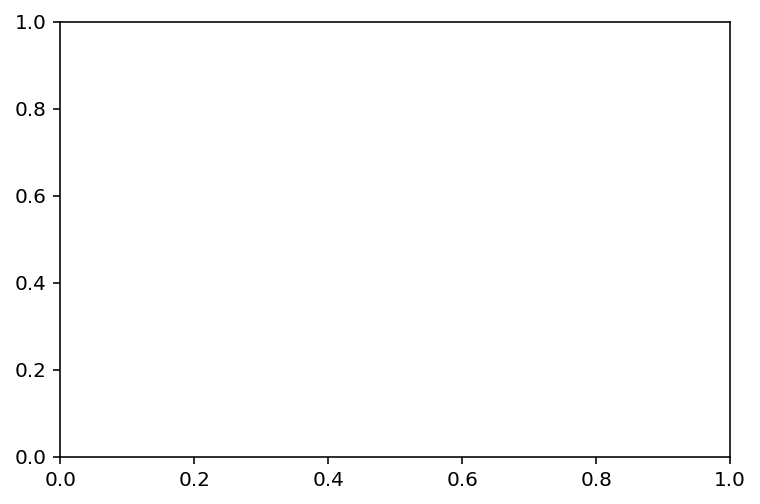

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser as dtp

#-------------------------------------------------------------------
#So that we only need to run this block:

#Given function for xml imports_list
import glob
import xml.etree.ElementTree as ET

# Function parseXML
# Input: xml_file
# Output array of elements with coordinates lat, lon, ele, time. 
def parseXML(xml_file):
    tree = ET.ElementTree(file=xml_file)
    root = tree.getroot()
    xml=[]
    for child in root[1]:
        if child.tag == "{http://www.topografix.com/GPX/1/1}trkseg":
            for step_child in child:
                evt={} # declare a new dictionary
                evt['lat'] = step_child.get('lat')
                evt['lon'] = step_child.get('lon')
                evt['ele'] = step_child[0].text
                evt['time'] = step_child[1].text
                xml.append(evt)
    return xml

# Path may need adjusting, depending on folder configuration
xml_file = glob.glob('../data/activity_779202142.gpx')
xml = parseXML(xml_file[0])

#---------------------------------------------------------------------

###################################################################
###################################################################
######################## F U N C T I O N S ########################
###################################################################
###################################################################

def Pos(xml_input):
    """Turns a dictionary of latitudes, longitudes, elevations, and times into a set of lists, converting from strings to relevant data types. Because honestly who wants to work with dictionaries for this"""
    Lats = []
    Lons = []
    Eles = []
    Times = []
    for i in range (0, len(xml_input)):
        Lats.append(float(xml_input[i]['lat']))
        Lons.append(float(xml_input[i]['lon']))
        Eles.append(float(xml_input[i]['ele']))
        Times.append(dtp.parse(xml_input[i]['time']))
    return(Lats, Lons, Eles, Times)

def DiffList(input_list):
    """Gives the difference between adjacent elements in a list"""
    difflist = []
    for i in range (0, len(input_list) - 1):
        difflist.append(input_list[i + 1] - input_list[i])
    return(difflist)

def CartPos(Lat, Lon, LatOrig, LonOrig):
    """Finds the Cartesian coordinates of a point given it's latitude and longitude, realtive to an origin point. Only accurate over short distances"""
    rE = 6371 #Earth radius in km (I guess you can change this for marathons on other planets)
    D2R = ((2 * np.pi) / (360))
    YPos = ((float(Lat) - float(LatOrig)) * D2R) * rE
    XPos = (((float(Lon) - float(LonOrig)) * D2R) * rE) #Apparently I need some correction factor here, but I don't know what it is or how to implement it
    return(XPos, YPos)

def CartList(latlist, lonlist):
    """Gives lists of X & Y coordinates from lists of latitude & longitude coordinates. (Just an iterated version of CartPos)"""
    Xs = []
    Ys = []
    for i in range (0, len(latlist)):
        X, Y = CartPos(latlist[i], lonlist[i], latlist[0], lonlist[0])
        Xs.append(X)
        Ys.append(Y)
    return(Xs, Ys)

def GeneralListPlot(XList, YList, xlabel, ylabel):
    """A general function to plot 2 lists of floats, and label their axes"""
    plt.plot(XList, YList)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    return()

def CartPlot(latlist, lonlist):
    """Plots the route travelled, in Cartesian coordinates"""
    Xs, Ys = CartList(latlist, lonlist)
    GeneralListPlot(Xs,Ys,'X Position (km)','Y Position (km)')
    return()

def DiffT(time_1, time_2):
    """Finds the difference between 2 times in seconds"""
    t1 = time_1
    t2 = time_2
    return((t2 - t1).total_seconds() )

def TimeDiffList(time_list):
    """Finds the differences between neighbouring time elements of a list, in seconds, and outputs them as a list"""
    tDiffList = []
    for i in range (0, len(time_list) - 1):
        tDiffList.append(DiffT(time_list[i],time_list[i + 1]))
    return(tDiffList)

def absDistTrav(latlist, lonlist):
    """Gives the absolute distance travelled, given a list of latitude and longitude positions"""
    Xlist, Ylist = CartList(latlist, lonlist)
    absDList = []
    for i in range(0, len(latlist)): #lat & lon lists should be the same length.
        absDList.append( np.sqrt( ((Xlist[i])**2) + ((Ylist[i])**2) ) ) # Is this outputting negatives at some point? HOW?!?!
    TravDist = DiffList(absDList)
    return(TravDist)

def CumulativeList(List): ### This is kinda pointless, but ya know, I've done it now
    """Cumulatively sums a list of values, outputting a list"""
    CumuList = np.cumsum(List)
    return(CumuList)

def RelTime(time_list):
    """Gives the time relative to the start time"""
    Reltime = []
    for i in range(0, len(time_list)):
        Reltime.append( (time_list[i] - time_list[0]).total_seconds() )
    return(Reltime)

def Velocity(latlist, lonlist, time_list): # WIP
    dDist = DiffList( absDistTrav(latlist, lonlist) )
#     Dist = absDistTrav(latlist, lonlist)
    Time = RelTime(time_list)
    Vel = []
    for i in range (0, len(dDist)): #Hopefully both Dist & Time are same length
        Vel.append( dDist[i] / Time[i] )
    return(Vel)

###########################################################################################################
# DEAD BOYS - Functions that aren't useful/don't work/WIP                                                 #
#                                                                                                         #
# def DistTrav(dLat_list, dLon_list):                                                                     #
#     """Finds the distances traveled, in meters, along a list of changes in latitude and longitude"""    #
#     dLatRad, dLonRad = np.deg2rad([dLat_list, dLon_list])                                               #
#     dLatRad = dLat_list * ((2 * np.pi) / 360)                                                           #
#     dLonRad = dLon_list * ((2 * np.pi) / 360)                                                           #
#     dPhilist = []                                                                                       #
#     Distlist = []                                                                                       #
#     for i in range (0, len(dLatRad)): #Lat or Lon length should be the same, so can use either          #
#         dPhilist.apppend( sqrt( dLatRad[i] ** 2 + dLonRad[i] ** 2) )                                    #
#         Distlist.append( dPhilist[i] * 6371000) #Earth radius (m)                                       #
#     return(Distlist)                                                                                    #
#                                                                                                         #
# It didn't like this very much, so I'm staying with the loop method                                      #
# def GeneralDiff(input_list):                                                                            #
#     """Gives the differences of neighbouring elements in input_list, and outputs them as a list"""      #
#     dList = input_list[1:] - input_list[:-1]                                                            #
#     return(dList)                                                                                       #
#                                                                                                         #
# This is the same as the Diff function                                                                   #
# def TimeDiffList(time_list):                                                                            #
#     """Finds the differences between neighbouring time elements of a list, and outputs them as a list"""#
#     tDiffList = []                                                                                      #
#     for i in range (0, len(time_list) - 1):                                                             #
#         tDiffList.append(DiffT(time_list[i+1],timelist[i]))                                             #
#     return(tDiffList)                                                                                   #
#                                                                                                         #
# Another attempt at time that didn't work                                                                #
# def DiffT(xml_input):                                                                                   #
#     dts = []                                                                                            #
#     for i in range (0, len(xml) - 1):                                                                   #
#         dts.append(dtp.parse(xml[i + 1]['time']) - dtp.parse(xml[i]['time']))                           #
#     return(dts)                                                                                         #
#                                                                                                         #
# An attempt at time that didn't work                                                                     #
# def DiffT(input_times_list):                                                                            #
#     dffTlist = []                                                                                       #
#     for i in range (0, len(input_times_list) - 1):                                                      #
#         dffTlist.append(relativedelta(input_times_list[i], input_times_list[i + 1]))                    #
#     return(dffTlist)                                                                                    #
###########################################################################################################



###################################################################
###################################################################
#################### T H E   P R O G R A M M E ####################
###################################################################
###################################################################

lats, lons, eles, ts = Pos(xml) # Could probably have this as part of some function, or have Pos(xml) be called in any functions that use these 4 lists, but I don't feel like it's necessary right now, and it could potentially make the program slower overall.

CartPlot(lats, lons)

TravDist = absDistTrav(lats, lons)
CumuDist = CumulativeList(TravDist)
NewCumuDist = np.insert(CumuDist,0 ,0) # Cumulative list with a 0 on the front (as x = when t = 0)
RelativeTSeconds = RelTime(ts)
RelativeTMinutes = [x / 60 for x in RelativeTSeconds]

GeneralListPlot(RelativeTMinutes , NewCumuDist, 'Time (minutes)', 'Distance (km)') # How is it getting a reducing distance?

# GeneralListPlot(CumuDist, TimeDiffList(ts), 'Distance' ,'dt')  # This doesn't produce a pretty graph, need to change the function to be able to shift the graphs.

NewVelList = np.insert(Velocity (lats, lons, ts),0 ,0)
NewVelList = NewVelList * 1000
GeneralListPlot(RelativeTMinutes, NewVelList, 'Time (minutes)', 'Velocity(m/s)')



TotalTime = (ts[len(ts) - 1] - ts[0]).total_seconds()
print( "Time taken for marathon: ", TotalTime, "seconds")

# WHY IS NOTHING WORKING PROPERLY?!?!!? Given more time I'd start again. Can I suggest moving the deadline further? Given that some of us have other programming labs most of Tuesday.

In [34]:
## Tests and stuff ##

# print(dtp.parse(ts[3]).total_seconds())
# print(DiffT(xml[8].total_seconds))
# 
# dLats, dLons, dEles = Diff(lats), Diff(lons), Diff(eles)
# 
# diff = GeneralDiff(ts)
# diff = DiffT(ts[4],ts[5])
# print(diff)
# 
# print(RelTime)
# 